In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#chargement du dataset avec annotations
import pandas as pd

pd.set_option('display.max_colwidth', None)
df = pd.read_csv('/content/drive/My Drive/Colab_outputs/path_annotation.csv', index_col=0)

In [ ]:
#ajout d'une colonne pour classification
import numpy as np

df['hemo'] = np.where(df['annotation'] == '/content/drive/My Drive/Colab_outputs/black_mask.png', 0, 1)
df.head()

,filename,annotation,hemo
0,/content/drive/My Drive/Projet_AVC/Patients_CT/129/brain/2.jpg,/content/drive/My Drive/Colab_outputs/black_mask.png,0
1,/content/drive/My Drive/Projet_AVC/Patients_CT/129/brain/22.jpg,/content/drive/My Drive/Colab_outputs/black_mask.png,0
2,/content/drive/My Drive/Projet_AVC/Patients_CT/129/brain/25.jpg,/content/drive/My Drive/Colab_outputs/black_mask.png,0
3,/content/drive/My Drive/Projet_AVC/Patients_CT/129/brain/6.jpg,/content/drive/My Drive/Colab_outputs/black_mask.png,0
4,/content/drive/My Drive/Projet_AVC/Patients_CT/129/brain/23.jpg,/content/drive/My Drive/Colab_outputs/black_mask.png,0


In [ ]:
# on sépare le jeu d'entrainement et de test
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=2345)

#Il y a 318 masques d'hemorragie, on regarde la proportion de mask dans chaque groupe
count_blackmask_train = df_train[df_train.annotation == '/content/drive/My Drive/Colab_outputs/black_mask.png'].count()
prop_train = ((df_train.annotation.count() - count_blackmask_train)/df_train.annotation.count())*100
count_blackmask_test = df_test[df_test.annotation == '/content/drive/My Drive/Colab_outputs/black_mask.png'].count()
prop_test = ((df_test.annotation.count() - count_blackmask_test)/df_test.annotation.count())*100
print(f'proportion of hemmo in train :  {prop_train} %')
print(f'proportion of hemmo in test :  {prop_test} %')

# On est sur des proportions très semblables

proportion of hemmo in train :  filename      12.85
annotation    12.85
hemo          12.85
dtype: float64 %
proportion of hemmo in test :  filename      12.175649
annotation    12.175649
hemo          12.175649
dtype: float64 %


In [ ]:
#création un tf ne contenant que les masques hémorragiques de pour TEST

df_hemo = df[df.hemo == 1]
df_hemo

,filename,annotation,hemo
888,/content/drive/My Drive/Projet_AVC/Patients_CT/097/brain/16.jpg,/content/drive/My Drive/Projet_AVC/Patients_CT/097/brain/16_HGE_Seg.png,1
892,/content/drive/My Drive/Projet_AVC/Patients_CT/097/brain/19.jpg,/content/drive/My Drive/Projet_AVC/Patients_CT/097/brain/19_HGE_Seg.png,1
896,/content/drive/My Drive/Projet_AVC/Patients_CT/097/brain/21.jpg,/content/drive/My Drive/Projet_AVC/Patients_CT/097/brain/21_HGE_Seg.png,1
897,/content/drive/My Drive/Projet_AVC/Patients_CT/097/brain/24.jpg,/content/drive/My Drive/Projet_AVC/Patients_CT/097/brain/24_HGE_Seg.png,1
900,/content/drive/My Drive/Projet_AVC/Patients_CT/097/brain/17.jpg,/content/drive/My Drive/Projet_AVC/Patients_CT/097/brain/17_HGE_Seg.png,1
...,...,...,...
2484,/content/drive/My Drive/Projet_AVC/Patients_CT/049/brain/17.jpg,/content/drive/My Drive/Projet_AVC/Patients_CT/049/brain/17_HGE_Seg.png,1
2486,/content/drive/My Drive/Projet_AVC/Patients_CT/049/brain/21.jpg,/content/drive/My Drive/Projet_AVC/Patients_CT/049/brain/21_HGE_Seg.png,1
2487,/content/drive/My Drive/Projet_AVC/Patients_CT/049/brain/22.jpg,/content/drive/My Drive/Projet_AVC/Patients_CT/049/brain/22_HGE_Seg.png,1
2489,/content/drive/My Drive/Projet_AVC/Patients_CT/049/brain/27.jpg,/content/drive/My Drive/Projet_AVC/Patients_CT/049/brain/27_HGE_Seg.png,1


In [ ]:
### création des datasets de train

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
import tensorflow as tf

IMG_SHAPE = 256

#dilatation de la zone blanche
def dilatation(tensor):
    kernel = tf.ones((3,3,1))
    return tf.nn.dilation2d(input=tensor, filters=kernel, strides=(1,1,1,1), dilations=(1,1,1,1), padding="SAME", data_format="NHWC") 

def preprocessing_file(img):
  image = tf.image.resize(img, [IMG_SHAPE, IMG_SHAPE])
  image = tf.cast(image, tf.float32)/255
  return image

def preprocessing_annotation(mask):
    mask_annot = tf.image.resize(mask, [IMG_SHAPE, IMG_SHAPE], method = 'nearest')
    mask_annot = tf.expand_dims(mask_annot, axis=0)
    mask_annot = dilatation (mask_annot)
    mask_annot = tf.cast(mask_annot, tf.float32)/255
    return mask_annot[0]


seed = 123 # (IMPORTANT) to transform image and corresponding mask with same augmentation parameter.
image_datagen = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   preprocessing_function=preprocessing_file) #preprocessing_function = image_preprocessing custom fuction for each image you can use resnet one too.

mask_datagen = ImageDataGenerator(rotation_range=20,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 fill_mode="constant",
                                 cval=0,
                                 preprocessing_function=preprocessing_annotation)  #preprocessing_function = mask_preprocessing to make mask as feedable formate (256,256,1)

In [ ]:
### génération d'images sur le train

BATCH_SIZE = 32

image_generator = image_datagen.flow_from_dataframe(dataframe = df_train,
                                                 target_size = (IMG_SHAPE,IMG_SHAPE),
                                                 x_col='filename',
                                                 batch_size = BATCH_SIZE,
                                                 seed=seed,
                                                 class_mode = None)

mask_generator = mask_datagen.flow_from_dataframe(dataframe = df_train,
                                                 target_size = (IMG_SHAPE,IMG_SHAPE),
                                                 x_col='annotation',
                                                 batch_size = BATCH_SIZE,
                                                 seed=seed,
                                                 class_mode = None,
                                                 color_mode = "grayscale",
                                                  )

# création de génrateur de data pour hémo à des fins de vérifications visuelles

image_hemo_generator = image_datagen.flow_from_dataframe(dataframe = df_hemo,
                                                 target_size = (IMG_SHAPE,IMG_SHAPE),
                                                 x_col='filename',
                                                 batch_size = BATCH_SIZE,
                                                 seed=seed,
                                                 class_mode = None)

mask_hemo_generator = mask_datagen.flow_from_dataframe(dataframe = df_hemo,
                                                 target_size = (IMG_SHAPE,IMG_SHAPE),
                                                 x_col='annotation',
                                                 batch_size = BATCH_SIZE,
                                                 seed=seed,
                                                 class_mode = None,
                                                 color_mode = "grayscale",
                                                  )

Found 2000 validated image filenames.
Found 2000 validated image filenames.
Found 318 validated image filenames.
Found 318 validated image filenames.


In [ ]:
### création de datasets de test

#mettre les images dans un format correct et préparer les fonctions dont on aura besoin pour former notre dataset
import tensorflow as tf


def scale_down(image, mask):
    image = tf.cast(image, tf.float32)/255
    mask = tf.cast(mask, tf.float32)/255
    return image, mask

#dilatation de la zone blanche
def dilatation(tensor):
    kernel = tf.ones((3,3,1))
    return tf.nn.dilation2d(input=tensor, filters=kernel, strides=(1,1,1,1), dilations=(1,1,1,1), padding="SAME", data_format="NHWC") 

def load_and_preprocess(img_filepath, mask_filepath):
   
    img = tf.io.read_file(img_filepath)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SHAPE, IMG_SHAPE])

    mask = tf.io.read_file(mask_filepath)
    mask = tf.io.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_SHAPE, IMG_SHAPE], method = 'nearest')
    #ajout d'une dimension pour permettre la dilatation
    img, mask = scale_down(img, mask)
    mask = tf.expand_dims(mask, axis=0)

    mask = dilatation (mask)

    return img, mask[0]


input_img_paths_test, annotation_img_paths_test = df_test.filename, df_test.annotation

#pour test avec hemo
input_img_paths_test_hemo, annotation_img_paths_test_hemo = df_test.filename[df_test.hemo ==1], df_test.annotation[df_test.hemo ==1]

    
# Define test dataset from tensorflow
test = tf.data.Dataset.from_tensor_slices((input_img_paths_test, annotation_img_paths_test))

#pour test avec hemo
test_hemo = tf.data.Dataset.from_tensor_slices((input_img_paths_test_hemo, annotation_img_paths_test_hemo))

AUTO = tf.data.experimental.AUTOTUNE

test = (
    test
    .map(load_and_preprocess, num_parallel_calls=AUTO) # map function to load image and mask
    .batch(BATCH_SIZE) # Split in batch
    .prefetch(AUTO)
)

#pour test avec hemo

test_hemo = (
    test_hemo
    .map(load_and_preprocess, num_parallel_calls=AUTO) # map function to load image and mask
    .batch(BATCH_SIZE) # Split in batch
    .prefetch(AUTO)
)

(256, 256, 1)


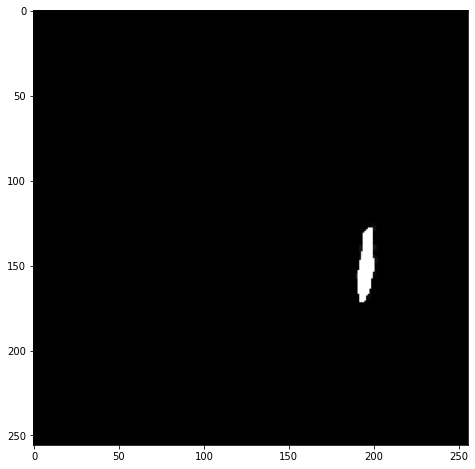

In [ ]:
#affichage de ce que retourne preprocessing_annotation

%matplotlib inline
import matplotlib.pyplot as plt

#l'index 905 correspond au patient 097 pour la coupe 23, cf juste au dessus
im, anno = load_and_preprocess(df.filename[905], df.annotation[905])

#l'index 905 correspond au patient 097 pour la coupe 23, cf juste au dessus
annotation = preprocessing_annotation(anno)

print(annotation.shape)

plt.figure(figsize=(15,8))
plt.imshow(tf.squeeze(anno), cmap='gray')
plt.show()

In [ ]:
#création d'un dataset train et test pour la classification

input_img_paths_train, hemo_train = df_train.filename, df_train.hemo
input_img_paths_test, hemo_test = df_test.filename, df_test.hemo
    
# Define test dataset from tensorflow
dataset_train  = tf.data.Dataset.from_tensor_slices((input_img_paths_train, hemo_train))
dataset_test = tf.data.Dataset.from_tensor_slices((input_img_paths_test, hemo_test))

def load_and_transform(img_filepath, y):
    img = tf.io.read_file(img_filepath)
    img = tf.io.decode_jpeg(img, channels=3)
    #redimensionnement
    img = tf.image.resize(img, [IMG_SHAPE, IMG_SHAPE])
    # On retourne les images redimensionnées 
    return img, y

AUTO = tf.data.experimental.AUTOTUNE

dataset_train = (
    dataset_train
    .map(load_and_transform, num_parallel_calls=AUTO) # map function to load image and mask
    .batch(BATCH_SIZE) # Split in batch
    .prefetch(AUTO)
)

dataset_test = (
    dataset_test
    .map(load_and_transform, num_parallel_calls=AUTO) # map function to load image and mask
    .batch(BATCH_SIZE) # Split in batch
    .prefetch(AUTO)
)

(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)


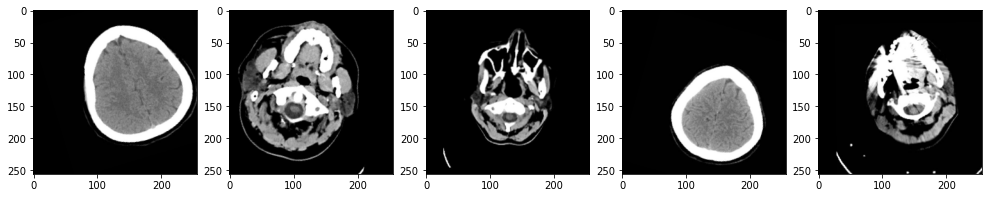

In [ ]:
# on vérifie les images de sortie de nos generator

import matplotlib.pyplot as plt

fig = plt.figure(figsize = (17,17))

for index in range(5):
    fig.add_subplot(1,5,index+1)
    img = image_generator.next()
    print(img.shape)  
    plt.imshow(img[0])
plt.show()

(32, 256, 256, 1)
(32, 256, 256, 1)
(32, 256, 256, 1)
(32, 256, 256, 1)
(32, 256, 256, 1)


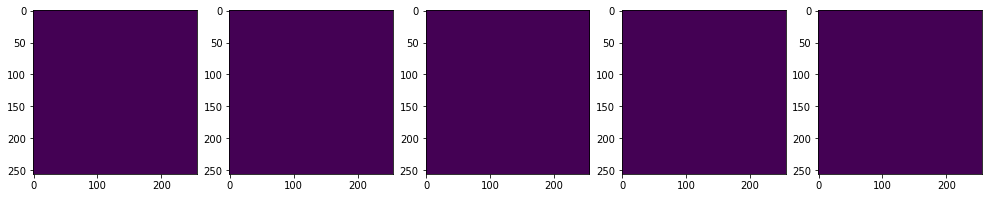

In [ ]:
fig = plt.figure(figsize = (17,17))

for index in range(5):
    fig.add_subplot(1,5,index+1)
    img = mask_generator.next()
    print(img.shape)  
    plt.imshow(img[0])
plt.show()

(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)


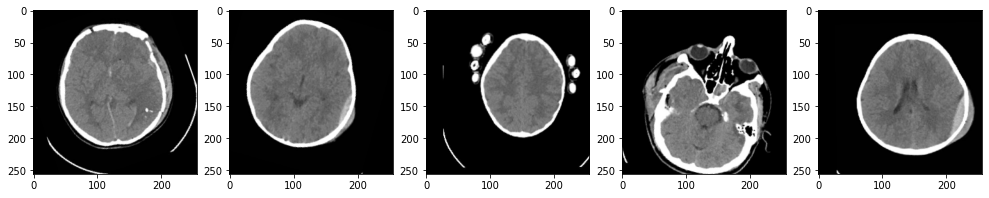

In [ ]:
# on vérifie les images de sortie de nos generator pour les hemo

fig = plt.figure(figsize = (17,17))

for index in range(5):
    fig.add_subplot(1,5,index+1)
    img = image_hemo_generator.next()
    print(img.shape)  
    plt.imshow(img[0])
plt.show()

(32, 256, 256, 1)
(32, 256, 256, 1)
(32, 256, 256, 1)
(32, 256, 256, 1)
(32, 256, 256, 1)


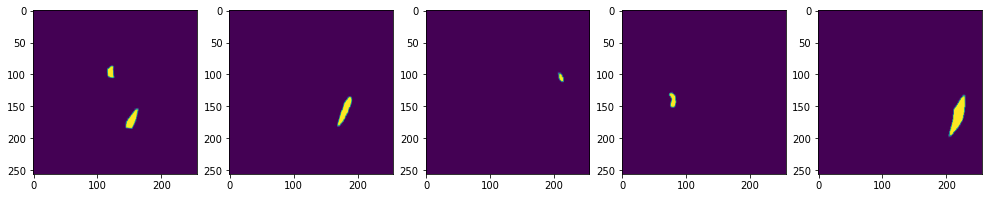

In [ ]:
# on vérifie les images de sortie de nos generator pour les hemo

fig = plt.figure(figsize = (17,17))

for index in range(5):
    fig.add_subplot(1,5,index+1)
    img = mask_hemo_generator.next()
    print(img.shape)  
    plt.imshow(img[0])
plt.show()

(32, 256, 256, 3)
(32, 256, 256, 1)
(29, 256, 256, 3)
(29, 256, 256, 1)


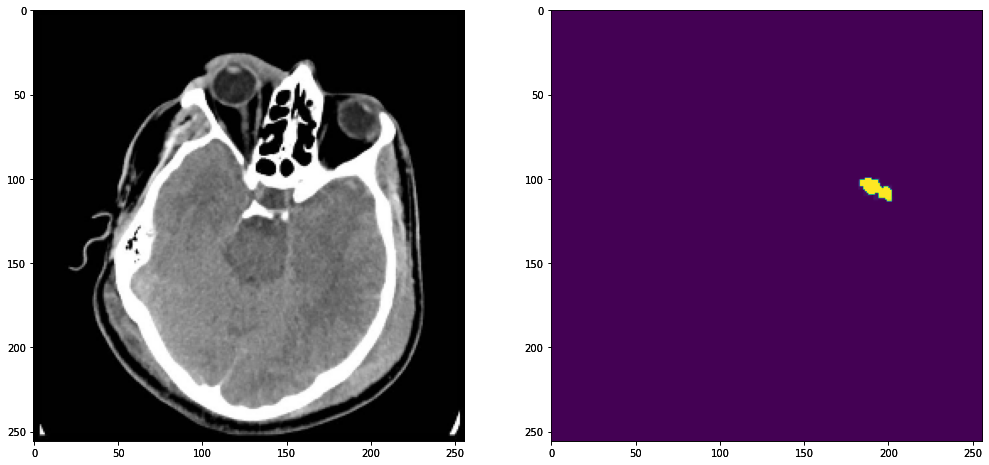

In [ ]:
# on vérifie les images de sortie de nos generator pour les hemo

fig = plt.figure(figsize = (17,17))

for img, mask in test_hemo.take(3):
    list_img = img.numpy()
    print(list_img.shape)
    fig.add_subplot(1,2,1)
    plt.imshow(list_img[-1,...])
    list_mask = mask.numpy()
    print(list_mask.shape)
    fig.add_subplot(1,2,2)
    plt.imshow(list_mask[-1,...])
plt.show()

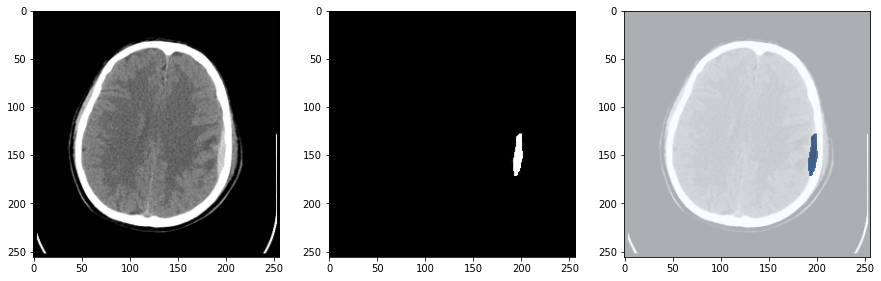

In [ ]:
#affichage de ce que retourne les fonctions

%matplotlib inline
import matplotlib.pyplot as plt

#l'index 905 correspond au patient 097 pour la coupe 23, cf juste au dessus
im, anno = load_and_preprocess(df.filename[905], df.annotation[905])

plt.figure(figsize=(15,8))
plt.subplot(131)
plt.imshow(im)
plt.subplot(132)
#plt.imshow(tf.reshape(anno, (128, 128)))
plt.imshow(tf.squeeze(anno), cmap='gray')
plt.subplot(133)
plt.imshow(im, cmap='gray')
plt.imshow(tf.squeeze(anno), cmap='Blues', alpha=0.7)
plt.show()

In [ ]:
train_generator = zip(image_generator, mask_generator)

(256, 256, 3)
(256, 256, 1)


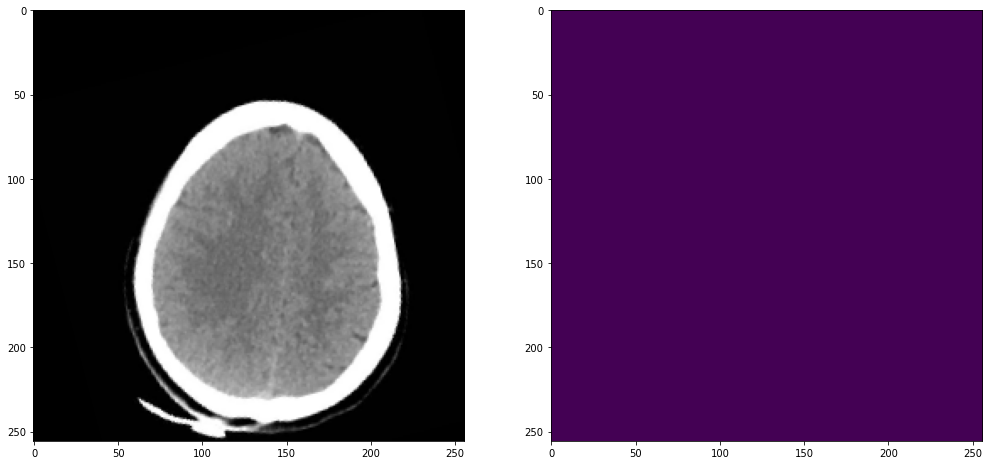

In [ ]:
#on vérifie visuellement que tout est ok

#len(list(train_generator)[0])
fig = plt.figure(figsize = (17,17))

img = next(train_generator)[0][0]
mask = next(train_generator)[1][0]
print(img.shape)
fig.add_subplot(1,2,1)
plt.imshow(img)
print(mask.shape)
fig.add_subplot(1,2,2)
plt.imshow(mask)
plt.show()


#print(next(train_generator)[0])

In [ ]:
                                                                         #########################
                                                                         ####  MODELISATION  #####
                                                                         #########################

#implémentation architecture UNET

from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

def unet(input_layer):

    #### encoder ####

  conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input_layer)
  conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  drop5 = Dropout(0.5)(conv5)

  layer1 = Flatten()(drop5)
  layer2 = Dense(units=128, activation = 'relu')(layer1)
  output_layer = Dense(units=1, activation = 'sigmoid')(layer2)


      #### decoder ####
  
  up6 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

  up7 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

  up8 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

  up9 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

  return conv10, output_layer

input_layer = Input(shape = (256,256,3))

output_model, output_encoder = unet(input_layer)

model_encoder = Model(inputs = input_layer, outputs = output_encoder)
model = Model(inputs = input_layer, outputs = output_model)


#model.compile(optimizer = "adam", loss = weightedLoss(K.losses.sparse_categorical_crossentropy, weights), metrics = ['accuracy'])
#model.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model_encoder.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ['accuracy'])
model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ['accuracy'])
#model.compile(optimizer = "adam", loss = focal_loss_custom(alpha=0.2, gamma=2.0), metrics = ['accuracy']) 

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  2320        ['conv2d[0][0]']                 
                                )                                                           

In [ ]:
### CALLBACKS

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


# EarlyStopping qui suit la valeur val_loss, arrête l'entraînement s'il n'y a pas de changement vers val_loss après 3 époques et conserve les meilleurs poids une fois que l'entraînement s'arrête
early_stopping = EarlyStopping(monitor = 'val_loss',
                    min_delta = 0.01,
                    mode = 'min',
                    patience = 3,
                    verbose = 1,
                    restore_best_weights = True)

#ReduceLROnPlateau qui suit la métrique val_loss, divise le coefficient d'apprentissage par 2 si au bout de 3 epochs, val_loss n'a pas varié de 0.01. 
#On attribue une pause de 2 epochs entre 2 cycles
reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss',
                        min_delta = 0.01,
                        patience = 3,
                        factor = 0.5, 
                        cooldown = 2,
                        verbose = 1)

In [ ]:
EPOCHS = 15

history_encoder = model_encoder.fit(dataset_train, epochs=EPOCHS, callbacks=[reduce_learning_rate, early_stopping], validation_data=dataset_test)
history_model = model.fit(train_generator, steps_per_epoch=int(len(df_train)/BATCH_SIZE), epochs=EPOCHS, callbacks=[reduce_learning_rate, early_stopping], validation_data = test)

Epoch 1/15
63/63 [==============================] - 665s 10s/step - loss: 74.3429 - accuracy: 0.8485 - val_loss: 0.3705 - val_accuracy: 0.8782 - lr: 0.0010
Epoch 2/15
63/63 [==============================] - 617s 10s/step - loss: 0.3309 - accuracy: 0.8715 - val_loss: 0.3901 - val_accuracy: 0.8782 - lr: 0.0010
Epoch 3/15
63/63 [==============================] - 607s 10s/step - loss: 0.3176 - accuracy: 0.8715 - val_loss: 0.3894 - val_accuracy: 0.8782 - lr: 0.0010
Epoch 4/15
63/63 [==============================] - ETA: 0s - loss: 0.3131 - accuracy: 0.8715
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Restoring model weights from the end of the best epoch: 1.
63/63 [==============================] - 610s 10s/step - loss: 0.3131 - accuracy: 0.8715 - val_loss: 0.3847 - val_accuracy: 0.8782 - lr: 0.0010
Epoch 4: early stopping
Epoch 1/15
62/62 [==============================] - 2154s 35s/step - loss: 0.0646 - accuracy: 0.0000e+00 - val_loss: 4.1960 - val_accurac

In [ ]:
model.save('/content/drive/My Drive/Colab_outputs/Unet.h5')

In [ ]:
import keras

model = keras.models.load_model('/content/drive/My Drive/Colab_outputs/Unet.h5')

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [ ]:
# 4 exemples avec masque prédit et réel

IMG_SHAPE = 128

def show_predictions(dataset, n=1):
    for image, mask in dataset.take(n):
        pred_mask = model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])

#pred_mask[0,...,1] / create_mask(pred_mask)

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        if i == 0:
            plt.imshow(display_list[i])
        else:
            plt.imshow(tf.squeeze(display_list[i]/2))
        plt.axis('off')
    plt.show()

        
show_predictions(test, 4)

NameError: ignored

In [ ]:
for image, mask in dataset.take(n):
    pred_mask = model.predict(image)
    display([image[0], mask[0], create_mask(pred_mask)])

1/1 [==============================] - 6s 6s/step


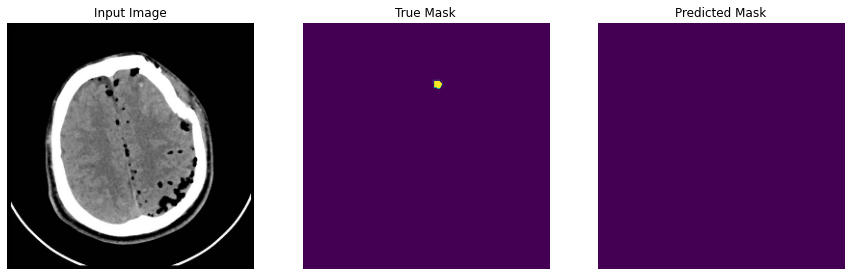

1/1 [==============================] - 8s 8s/step


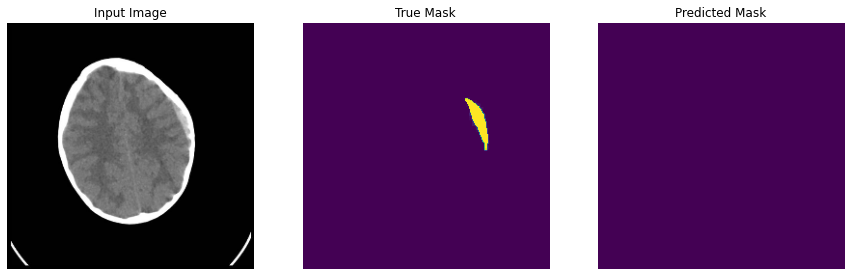

In [ ]:
show_predictions(test_hemo, 4)